<h1><span style="color:black; font-weight:bold"><u><center>HOF Data Modeling Pipeline</center></u></span></h1>

<p><span style="color:green; font-weight:bold">The following notebook takes the preprocessed data and uses it in a machine learning pipeline for the purpose of Hall of Fame prediction. Techniques/Methods such as clustering, XGB, and RandomForest are used in this modeling pipeline. All stats are pulled from BaseballReference.com and Stathead.com</span></p>

In [192]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PowerTransformer
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import calinski_harabasz_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report
from xgboost import XGBRegressor, XGBClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import silhouette_score
from sklearn.mixture import GaussianMixture
from imblearn.pipeline import make_pipeline
from imblearn.over_sampling import BorderlineSMOTE
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import plotly.express as px
from scipy import stats
import seaborn as sns
import xgboost as xgb
import pandas as pd
import numpy as np
import joblib
import random 
import math
import os

In [53]:
col_order = ['Player', 'Team', 'Season', 'Age', 'G', 'PA', 'AB',
       'R', 'H', '1B', '2B', '3B', 'HR', 'RBI', 'XBH', 'SB', 'CS', 'BB', 'SO', 'BA',
       'OBP', 'SLG', 'OPS', 'TB', 'GIDP', 'HBP', 'SH', 'SF', 'IBB',
       'WAR', 'GGs', 'SSs', 'Bat_Titles', 'All_Stars', 'MVPs', 'Pos', 'status']

inactive_data = pd.read_csv('inactive_player_data.csv')
inactive_data = inactive_data[col_order]
active_data = pd.read_csv('new_active_player_data.csv')
active_data = active_data[col_order]

In [54]:
inactive_data

,Player,Team,Season,Age,G,PA,AB,R,H,1B,...,SF,IBB,WAR,GGs,SSs,Bat_Titles,All_Stars,MVPs,Pos,status
0,Adam Jones,ARI,14,33,137,528,485,66,126,84,...,3.0,2.0,-0.7,0,0,0,0,0,9,retired
1,Adam Jones,BAL,3,22,132,514,477,61,129,92,...,5.0,0.0,2.0,0,0,0,0,0,8,retired
2,Adam Jones,BAL,4,23,119,519,473,83,131,87,...,3.0,3.0,2.6,1,0,0,1,0,8,retired
3,Adam Jones,BAL,5,24,149,621,581,76,165,116,...,2.0,1.0,2.5,0,0,0,0,0,8,retired
4,Adam Jones,BAL,6,25,151,618,567,68,159,106,...,12.0,2.0,3.3,0,0,0,0,0,8,retired
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5207,Édgar Rentería,STL,5,23,150,643,562,94,156,107,...,9.0,3.0,2.2,0,1,0,0,0,6,retired
5208,Édgar Rentería,STL,6,24,141,549,493,54,128,96,...,6.0,4.0,1.5,0,0,0,0,0,6,retired
5209,Édgar Rentería,STL,7,25,152,609,544,77,166,117,...,5.0,7.0,4.3,1,1,0,0,0,6,retired
5210,Édgar Rentería,STL,8,26,157,663,587,96,194,133,...,7.0,12.0,5.6,1,1,0,0,0,6,retired


In [55]:
active_data

,Player,Team,Season,Age,G,PA,AB,R,H,1B,...,SF,IBB,WAR,GGs,SSs,Bat_Titles,All_Stars,MVPs,Pos,status
0,Christian Yelich,MIA,1,21,62,273,240,34,69,52,...,1,1,1.6,0,0,0,0,0,7,active
1,Christian Yelich,MIA,2,22,144,660,582,94,165,120,...,2,3,3.8,1,0,0,0,0,7,active
2,Christian Yelich,MIA,3,23,126,525,476,63,143,104,...,0,2,3.6,0,0,0,0,0,7,active
3,Christian Yelich,MIA,4,24,155,659,578,78,172,110,...,5,4,4.9,0,1,0,0,0,7,active
4,Christian Yelich,MIA,5,25,156,695,602,100,170,114,...,6,4,3.7,0,0,0,0,0,8,active
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1769,José Abreu,CHW,5,31,128,553,499,68,132,73,...,6,7,2.1,0,1,0,1,0,3,active
1770,José Abreu,CHW,6,32,159,693,634,85,180,108,...,10,4,2.3,0,0,0,1,0,3,active
1771,José Abreu,CHW,7,33,60,262,240,43,76,42,...,1,1,2.7,0,1,0,0,1,3,active
1772,José Abreu,CHW,8,34,152,659,566,86,148,86,...,10,3,3.0,0,0,0,0,0,3,active


<h3><span style="color:purple; font-weight:bold">Encoding Position Column</span></h3>

<p><span style="color:green; font-weight:bold">The position column is converted into dummy variables for proper modeling practice. Additionally, pitchers with eligible hitting stats are dropped from the data to avoid any influence on the hitting data.</span></p>

In [56]:
inactive_dummies = pd.get_dummies(inactive_data['Pos'], prefix='Pos')
temp_inact_stat = inactive_data['status']
inactive_data.drop(['Pos', 'status'], axis=1, inplace=True)
inactive_data = pd.concat([inactive_data, inactive_dummies, temp_inact_stat], axis=1)

active_dummies = pd.get_dummies(active_data['Pos'], prefix='Pos')
temp_act_stat = active_data['status']
active_data.drop(['Pos', 'status'], axis=1, inplace=True)
active_data = pd.concat([active_data, active_dummies, temp_act_stat], axis=1)

inactive_data = inactive_data[inactive_data['Pos_1'] != True]
active_data = active_data[active_data['Pos_1'] != True]
inactive_data.drop(['Pos_1'], axis=1, inplace=True)
active_data.drop(['Pos_1'], axis=1, inplace=True)

In [57]:
inactive_data

,Player,Team,Season,Age,G,PA,AB,R,H,1B,...,Pos_2,Pos_3,Pos_4,Pos_5,Pos_6,Pos_7,Pos_8,Pos_9,Pos_10,status
0,Adam Jones,ARI,14,33,137,528,485,66,126,84,...,False,False,False,False,False,False,False,True,False,retired
1,Adam Jones,BAL,3,22,132,514,477,61,129,92,...,False,False,False,False,False,False,True,False,False,retired
2,Adam Jones,BAL,4,23,119,519,473,83,131,87,...,False,False,False,False,False,False,True,False,False,retired
3,Adam Jones,BAL,5,24,149,621,581,76,165,116,...,False,False,False,False,False,False,True,False,False,retired
4,Adam Jones,BAL,6,25,151,618,567,68,159,106,...,False,False,False,False,False,False,True,False,False,retired
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5207,Édgar Rentería,STL,5,23,150,643,562,94,156,107,...,False,False,False,False,True,False,False,False,False,retired
5208,Édgar Rentería,STL,6,24,141,549,493,54,128,96,...,False,False,False,False,True,False,False,False,False,retired
5209,Édgar Rentería,STL,7,25,152,609,544,77,166,117,...,False,False,False,False,True,False,False,False,False,retired
5210,Édgar Rentería,STL,8,26,157,663,587,96,194,133,...,False,False,False,False,True,False,False,False,False,retired


In [58]:
active_data

,Player,Team,Season,Age,G,PA,AB,R,H,1B,...,Pos_2,Pos_3,Pos_4,Pos_5,Pos_6,Pos_7,Pos_8,Pos_9,Pos_10,status
0,Christian Yelich,MIA,1,21,62,273,240,34,69,52,...,False,False,False,False,False,True,False,False,False,active
1,Christian Yelich,MIA,2,22,144,660,582,94,165,120,...,False,False,False,False,False,True,False,False,False,active
2,Christian Yelich,MIA,3,23,126,525,476,63,143,104,...,False,False,False,False,False,True,False,False,False,active
3,Christian Yelich,MIA,4,24,155,659,578,78,172,110,...,False,False,False,False,False,True,False,False,False,active
4,Christian Yelich,MIA,5,25,156,695,602,100,170,114,...,False,False,False,False,False,False,True,False,False,active
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1769,José Abreu,CHW,5,31,128,553,499,68,132,73,...,False,True,False,False,False,False,False,False,False,active
1770,José Abreu,CHW,6,32,159,693,634,85,180,108,...,False,True,False,False,False,False,False,False,False,active
1771,José Abreu,CHW,7,33,60,262,240,43,76,42,...,False,True,False,False,False,False,False,False,False,active
1772,José Abreu,CHW,8,34,152,659,566,86,148,86,...,False,True,False,False,False,False,False,False,False,active


<h2><span style="color:blue; font-weight:bold"><u>Soft Clustering</u></span></h2>

In [60]:
def fix_skew(df, col, min_abs_skew=0.5):
    skew = df[col].skew()
    abs_skew = abs(skew)
    
    if abs_skew <= min_abs_skew:
        return
    
    if skew < 0:
        max_val = df[col].max()
        df[col] = max_val - df[col] + 1 
        
    min_val = df[col].min()
    if min_val <= 0:
        offset = abs(min_val) + 1e-6
        df[col] = df[col] + offset
    
    if min_abs_skew <= abs_skew < 1.0:
        df[col] = np.sqrt(df[col])
    elif abs_skew >= 1.0:
        df[col] = np.log1p(df[col]) 

def fix_seasons(df):
    for player in df['Player'].unique():
        debut = df.loc[df['Player'] == player, 'Season'].min()
        df.loc[df['Player'] == player, 'Season'] = df.loc[df['Player'] == player, 'Season'] - debut + 1

def find_optimal_clusters(data, max_clusters=8):
    scores = []
    
    for k in range(2, max_clusters+1):
        gmm = GaussianMixture(n_components=k, covariance_type='full', random_state=42)
        clusters = gmm.fit_predict(data)
        score = silhouette_score(data, clusters)
        scores.append(score)
        print(f"Clusters: {k} - Silhouette: {score:.3f}")
    
    optimal_k = np.argmax(scores) + 2
    print(f"Optimal cluster count: {optimal_k}")
    return optimal_k

In [59]:
for i in inactive_data.columns[2:44]:
    skew = inactive_data[i].skew()
    print(f'{i} skewness: {skew}')

Season skewness: 0.9943603714406879
Age skewness: 0.17427974366392981
G skewness: -1.4238072232539214
PA skewness: -1.093369250644647
AB skewness: -1.053047240985612
R skewness: -0.3186983429104098
H skewness: -0.6901117545366012
1B skewness: -0.3677206837982762
2B skewness: -0.05221911154006465
3B skewness: 1.6111001852634304
HR skewness: 0.6938805261295057
RBI skewness: -0.0032976818849739546
XBH skewness: -0.075501059500814
SB skewness: 2.4271469879872285
CS skewness: 1.7143319909394525
BB skewness: 0.49337552958844966
SO skewness: 0.24848040439879193
BA skewness: -1.0859354548542037
OBP skewness: -0.9439857124329137
SLG skewness: -0.21433344119033423
OPS skewness: -0.4949259616198078
TB skewness: -0.4760397077783871
GIDP skewness: 0.4504292912998146
HBP skewness: 2.546096079331244
SH skewness: 2.8540769866595808
SF skewness: 0.714848323278483
IBB skewness: 3.331110648503943
WAR skewness: 0.49560738929513615
GGs skewness: 2.2640742574278403
SSs skewness: 2.9192241265365255
Bat_Title

<h3><span style="color:purple; font-weight:bold">PCA Analysis</span></h3>

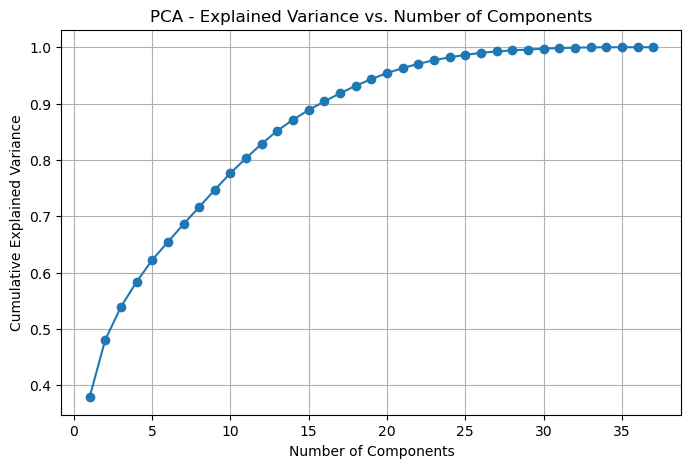

Component 1: 0.3789
Component 2: 0.4806
Component 3: 0.5391
Component 4: 0.5836
Component 5: 0.6224
Component 6: 0.6545
Component 7: 0.6859
Component 8: 0.7166
Component 9: 0.7471
Component 10: 0.7768
Component 11: 0.8032
Component 12: 0.8288
Component 13: 0.8521
Component 14: 0.8715
Component 15: 0.8887
Component 16: 0.9039
Component 17: 0.9184
Component 18: 0.9316
Component 19: 0.9435
Component 20: 0.9541
Component 21: 0.9631
Component 22: 0.9705
Component 23: 0.9771
Component 24: 0.9821
Component 25: 0.9864
Component 26: 0.9901
Component 27: 0.9925
Component 28: 0.9944
Component 29: 0.9959
Component 30: 0.9973
Component 31: 0.9984
Component 32: 0.9993
Component 33: 0.9997
Component 34: 0.9999
Component 35: 1.0000
Component 36: 1.0000
Component 37: 1.0000


In [61]:
test_inactive = inactive_data.copy()
test_inactive.drop(['GGs', 'SSs', 'Bat_Titles', 'All_Stars'], axis=1, inplace=True)

test_inactive_X = test_inactive[test_inactive.columns[2:39]].dropna()

for i in test_inactive_X.columns[2:31]:
    fix_skew(test_inactive_X, i)

test_inactive_X_scaled = StandardScaler().fit_transform(test_inactive_X)

test_pca = PCA()
test_pca.fit_transform(test_inactive_X_scaled)

explained_variance = test_pca.explained_variance_ratio_
cumulative_variance = explained_variance.cumsum()

plt.figure(figsize=(8, 5))
plt.plot(range(1, len(cumulative_variance)+1), cumulative_variance, marker='o')
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("PCA - Explained Variance vs. Number of Components")
plt.grid(True)
plt.show()

for i, var in enumerate(cumulative_variance):
    print(f"Component {i+1}: {var:.4f}")

<h3><span style="color:purple; font-weight:bold">Apply Clustering Using PCA</span></h3>
<p><span style="color:green; font-weight:bold">Component variance analysis reveals 11 components to be a good baseline for clustering. Now we will try to find the optimal amount of clusters in terms of our transformed inactive data, then apply it to the active data.</span></p>

In [62]:
test_inactive = inactive_data.copy()
test_inactive.drop(['GGs', 'SSs', 'Bat_Titles', 'All_Stars', 'MVPs'], axis=1, inplace=True)

test_active = active_data.copy()
test_active.drop(['GGs', 'SSs', 'Bat_Titles', 'All_Stars', 'MVPs'], axis=1, inplace=True)

test_inactive_X = test_inactive[test_inactive.columns[2:39]].dropna()
test_active_X = test_active[test_active.columns[2:39]].dropna()

for i in test_inactive_X.columns[2:31]:
    fix_skew(test_inactive_X, i)

for i in test_active_X.columns[2:31]:
    fix_skew(test_active_X, i)

pca = PCA(n_components=11)
inactive_X_pca = pca.fit_transform(test_inactive_X)
active_X_pca = pca.transform(test_active_X)

best_k = find_optimal_clusters(inactive_X_pca)

gmm = GaussianMixture(n_components=2, covariance_type='full', random_state=42)
gmm.fit(inactive_X_pca)

cluster_probs_inactive = gmm.predict_proba(inactive_X_pca)
cluster_probs_active = gmm.predict_proba(active_X_pca)

Clusters: 2 - Silhouette: 0.463
Clusters: 3 - Silhouette: 0.285
Clusters: 4 - Silhouette: 0.212
Clusters: 5 - Silhouette: 0.136
Clusters: 6 - Silhouette: 0.098
Clusters: 7 - Silhouette: 0.111
Clusters: 8 - Silhouette: 0.078
Optimal cluster count: 2


<p><span style="color:green; font-weight:bold">Here we only see the results of using 11 components, but testing showed that increasing the number of components did not signicantly increase the silhoutte score. Past clustering attempts utilized more clusters but results were finnicky. The purpose of this specific clustering was to judge purely season-by-season performance, properly encoding the position values and excluding awards. PCA and clustering are fit to the inactive data, then used on the active dataset as well.</span></p>

In [63]:
for i in range(cluster_probs_inactive.shape[1]):
    test_inactive[f'Cluster_{i}_Prob'] = cluster_probs_inactive[:, i]

for i in range(cluster_probs_active.shape[1]):
    test_active[f'Cluster_{i}_Prob'] = cluster_probs_active[:, i]

In [64]:
test_inactive

,Player,Team,Season,Age,G,PA,AB,R,H,1B,...,Pos_4,Pos_5,Pos_6,Pos_7,Pos_8,Pos_9,Pos_10,status,Cluster_0_Prob,Cluster_1_Prob
0,Adam Jones,ARI,14,33,137,528,485,66,126,84,...,False,False,False,False,False,True,False,retired,0.999792,2.077003e-04
1,Adam Jones,BAL,3,22,132,514,477,61,129,92,...,False,False,False,False,True,False,False,retired,0.999684,3.158467e-04
2,Adam Jones,BAL,4,23,119,519,473,83,131,87,...,False,False,False,False,True,False,False,retired,0.998860,1.140047e-03
3,Adam Jones,BAL,5,24,149,621,581,76,165,116,...,False,False,False,False,True,False,False,retired,1.000000,6.611121e-09
4,Adam Jones,BAL,6,25,151,618,567,68,159,106,...,False,False,False,False,True,False,False,retired,1.000000,2.675124e-07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5207,Édgar Rentería,STL,5,23,150,643,562,94,156,107,...,False,False,True,False,False,False,False,retired,0.999613,3.869356e-04
5208,Édgar Rentería,STL,6,24,141,549,493,54,128,96,...,False,False,True,False,False,False,False,retired,0.946248,5.375174e-02
5209,Édgar Rentería,STL,7,25,152,609,544,77,166,117,...,False,False,True,False,False,False,False,retired,0.999999,5.397178e-07
5210,Édgar Rentería,STL,8,26,157,663,587,96,194,133,...,False,False,True,False,False,False,False,retired,1.000000,7.583887e-14


In [65]:
test_active

,Player,Team,Season,Age,G,PA,AB,R,H,1B,...,Pos_4,Pos_5,Pos_6,Pos_7,Pos_8,Pos_9,Pos_10,status,Cluster_0_Prob,Cluster_1_Prob
0,Christian Yelich,MIA,1,21,62,273,240,34,69,52,...,False,False,False,True,False,False,False,active,1.0,2.461112e-104
1,Christian Yelich,MIA,2,22,144,660,582,94,165,120,...,False,False,False,True,False,False,False,active,1.0,0.000000e+00
2,Christian Yelich,MIA,3,23,126,525,476,63,143,104,...,False,False,False,True,False,False,False,active,1.0,0.000000e+00
3,Christian Yelich,MIA,4,24,155,659,578,78,172,110,...,False,False,False,True,False,False,False,active,1.0,0.000000e+00
4,Christian Yelich,MIA,5,25,156,695,602,100,170,114,...,False,False,False,False,True,False,False,active,1.0,0.000000e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1769,José Abreu,CHW,5,31,128,553,499,68,132,73,...,False,False,False,False,False,False,False,active,1.0,0.000000e+00
1770,José Abreu,CHW,6,32,159,693,634,85,180,108,...,False,False,False,False,False,False,False,active,1.0,0.000000e+00
1771,José Abreu,CHW,7,33,60,262,240,43,76,42,...,False,False,False,False,False,False,False,active,1.0,7.260854e-83
1772,José Abreu,CHW,8,34,152,659,566,86,148,86,...,False,False,False,False,False,False,False,active,1.0,0.000000e+00


<h2><span style="color:blue; font-weight:bold"><u>Creating Final Datasets/Feature Set</u></span></h2>

<p><span style="color:green; font-weight:bold">The season-by-season data will be converted into career totals for both the inactive and active data. This will be used in an initial classification model to get a sense of what features matter in HOF prediction, using a regularization method.</span></p>

In [66]:
def calc_bat_avg(hits, at_bats):
    if at_bats == 0:
        return 0.0
    return round((hits/at_bats), 3)

def calc_obp(hits, walks, hbp, at_bats, sf):
    first = hits + walks + hbp
    second = at_bats + hbp + sf
    if second == 0:
        return 0.0
    return round((first/second), 3)

def calc_slug(singles, doubles, triples, hrs, at_bats):
    if at_bats == 0:
        return 0.0
    doubles = doubles * 2
    triples = triples * 3
    home_bs = hrs * 4
    return round(((singles+doubles+triples+home_bs)/at_bats), 3)

def calc_ops(obp, slug):
    return round((obp+slug), 3)

def total_df(df):
    col_names = ['Player',  'Age', 'Season_num', 'G', 'PA', 'AB', 'R', 'H', '1B',
       '2B', '3B', 'HR', 'RBI', 'XBH', 'SB', 'CS', 'BB', 'SO', 'BA', 'OBP',
       'SLG', 'OPS', 'TB', 'GIDP', 'HBP', 'SH', 'SF', 'IBB', 'WAR',
       'Pos_2', 'Pos_3', 'Pos_4', 'Pos_5', 'Pos_6', 'Pos_7', 'Pos_8', 'Pos_9',
       'Pos_10',  'GGs', 'SSs', 'Bat_Titles', 'All_Stars', 'MVPs',
        'Cluster_0_Prob', 'Cluster_1_Prob', 'status']

    empty = []
    for player in df['Player'].unique():
        player_df = df[df['Player'] == player]

        hits = player_df['H'].sum()
        at_bats = player_df['AB'].sum()
        walks = player_df['BB'].sum()
        hbp = player_df['HBP'].sum()
        sf = player_df['SF'].sum()
        singles = player_df['1B'].sum()
        doubles = player_df['2B'].sum()
        triples = player_df['3B'].sum()
        hrs = player_df['HR'].sum()

        obp = calc_obp(hits, walks, hbp, at_bats, sf)
        slg = calc_slug(singles, doubles, triples, hrs, at_bats)

        total_pa = player_df['PA'].sum()
        avg_cluster0 = np.average(player_df['Cluster_0_Prob'], weights=player_df['PA'])
        avg_cluster1 = np.average(player_df['Cluster_1_Prob'], weights=player_df['PA'])

        temp = [player, player_df['Age'].max(), player_df['Season'].nunique(), player_df['G'].sum(),
                total_pa, at_bats, player_df['R'].sum(), hits, singles, doubles, triples, hrs,
                player_df['RBI'].sum(), player_df['XBH'].sum(), player_df['SB'].sum(), player_df['CS'].sum(),
                walks, player_df['SO'].sum(), calc_bat_avg(hits, at_bats), obp, slg, calc_ops(obp, slg),
                player_df['TB'].sum(), player_df['GIDP'].sum(), hbp, player_df['SH'].sum(), sf, 
                player_df['IBB'].sum(), player_df['WAR'].sum(), 
                player_df['Pos_2'].values[0], player_df['Pos_3'].values[0], player_df['Pos_4'].values[0],
                player_df['Pos_5'].values[0], player_df['Pos_6'].values[0], player_df['Pos_7'].values[0],
                player_df['Pos_8'].values[0], player_df['Pos_9'].values[0], player_df['Pos_10'].values[0],
                player_df['GGs'].sum(), player_df['SSs'].sum(), player_df['Bat_Titles'].sum(),
                player_df['All_Stars'].sum(), player_df['MVPs'].sum(), avg_cluster0, avg_cluster1, 
                player_df['status'].unique()[0]]
        
        empty.append(temp)

    new_df = pd.DataFrame(data=empty, columns=col_names)
    return new_df

In [163]:
awards = ['GGs', 'SSs', 'Bat_Titles', 'All_Stars', 'MVPs']
awards_inactive = inactive_data[awards]

final_inactive = pd.concat([test_inactive.copy(), awards_inactive], axis=1)
final_inactive = total_df(final_inactive)

awards = ['GGs', 'SSs', 'Bat_Titles', 'All_Stars', 'MVPs']
awards_active = active_data[awards]

final_active = pd.concat([test_active.copy(), awards_active], axis=1)
final_active = total_df(final_active)

<p><span style="color:green; font-weight:bold">The performance data that contains the clustering is merged with its matching award counts for the final dataset. Below will be a list of the feature set before regularization is used to give a glimpse into the penalization results.</span></p>

In [164]:
final_inactive.columns

Index(['Player', 'Age', 'Season_num', 'G', 'PA', 'AB', 'R', 'H', '1B', '2B',
       '3B', 'HR', 'RBI', 'XBH', 'SB', 'CS', 'BB', 'SO', 'BA', 'OBP', 'SLG',
       'OPS', 'TB', 'GIDP', 'HBP', 'SH', 'SF', 'IBB', 'WAR', 'Pos_2', 'Pos_3',
       'Pos_4', 'Pos_5', 'Pos_6', 'Pos_7', 'Pos_8', 'Pos_9', 'Pos_10', 'GGs',
       'SSs', 'Bat_Titles', 'All_Stars', 'MVPs', 'Cluster_0_Prob',
       'Cluster_1_Prob', 'status'],
      dtype='object')

<h3><span style="color:purple; font-weight:bold">Applying Initial Regularization</span></h3>
<p><span style="color:green; font-weight:bold">The numeric columns are seperated below for scaling and the status column is encoded for prediction. A logistic regression model is used with an L1 penalty included to rid the dataset of features deemed insignificant.</span></p>

In [165]:
numeric = ['Age', 'Season_num', 'G', 'PA', 'AB', 'R', 'H', '1B', '2B',
       '3B', 'HR', 'RBI', 'XBH', 'SB', 'CS', 'BB', 'SO', 'BA', 'OBP', 'SLG',
       'OPS', 'TB', 'GIDP', 'HBP', 'SH', 'SF', 'IBB', 'WAR', 'Cluster_0_Prob',
       'Cluster_1_Prob'] 

dummies = ['Pos_2', 'Pos_3', 'Pos_4', 'Pos_5', 'Pos_6', 'Pos_7', 'Pos_8', 
           'Pos_9', 'Pos_10', 'GGs', 'SSs', 'Bat_Titles', 'All_Stars', 'MVPs']

X = final_inactive.iloc[:, 1:45]
scaler = StandardScaler()

X_scaled = scaler.fit_transform(X[numeric])
X_scaled = pd.DataFrame(X_scaled, columns=numeric, index=X.index)
X_test = pd.concat([X_scaled, X[dummies]], axis=1)
y = final_inactive['status'].map({'hof': 1, 'retired': 0})

logistic_lasso = LogisticRegressionCV(cv=5, penalty='l1', solver='liblinear', max_iter=10_000).fit(X_test, y)

selected_features = X_test.columns[logistic_lasso.coef_[0] != 0]
print("Selected features:", selected_features)

Selected features: Index(['Age', 'Season_num', 'AB', 'R', '2B', '3B', 'HR', 'RBI', 'XBH', 'SB',
       'CS', 'SO', 'BA', 'SLG', 'OPS', 'GIDP', 'HBP', 'SH', 'SF', 'IBB', 'WAR',
       'Cluster_0_Prob', 'Cluster_1_Prob', 'Pos_2', 'Pos_5', 'Pos_6', 'Pos_7',
       'Pos_8', 'Pos_9', 'GGs', 'SSs', 'All_Stars', 'MVPs'],
      dtype='object')


In [167]:
print(len(final_inactive.columns[1:45]))
print(len(selected_features))

44
33


In [166]:
for i in range(len(X_test.columns)):
    print(f'Learned Coefficient for {X_test.columns[i]}: {logistic_lasso.coef_[0][i]}')

Learned Coefficient for Age: 0.5129620509147892
Learned Coefficient for Season_num: -1.3351720670896992
Learned Coefficient for G: 0.0
Learned Coefficient for PA: 0.0
Learned Coefficient for AB: 3.0331064837653976
Learned Coefficient for R: -2.616492954891495
Learned Coefficient for H: 0.0
Learned Coefficient for 1B: 0.0
Learned Coefficient for 2B: -0.4655587722321724
Learned Coefficient for 3B: 0.6586272517481091
Learned Coefficient for HR: -1.1030381272328325
Learned Coefficient for RBI: 3.6635961247902578
Learned Coefficient for XBH: -0.7839556527281603
Learned Coefficient for SB: 0.7846181365433754
Learned Coefficient for CS: -0.42189077147698173
Learned Coefficient for BB: 0.0
Learned Coefficient for SO: -0.2987970470441032
Learned Coefficient for BA: 0.4193272843130052
Learned Coefficient for OBP: 0.0
Learned Coefficient for SLG: 0.4725778608722324
Learned Coefficient for OPS: 1.37563938246842
Learned Coefficient for TB: 0.0
Learned Coefficient for GIDP: -0.5706163103474674
Learn

<p><span style="color:green; font-weight:bold">From the above results we can see a reduction in feature size. Printed out is the coefficient values the logistic regression model came up with which gives a glimpse into the level of influence of each feature from the original feature set. Below we look further into the collinearity of the remaining features, to see if we can reduce anymore features.</span></p>

In [168]:
corr_mat = final_inactive[selected_features].corr()

corr_check = {}
for i in corr_mat.index:
    for j in corr_mat.columns:
        if corr_mat.loc[i, j] >= 0.7:
            if i != j:
                print(f"{i} + {j}")

Age + Season_num
Season_num + Age
Season_num + AB
AB + Season_num
AB + R
AB + 2B
AB + RBI
AB + XBH
R + AB
R + 2B
R + RBI
R + XBH
R + WAR
2B + AB
2B + R
2B + RBI
2B + XBH
HR + RBI
HR + XBH
HR + SLG
HR + OPS
RBI + AB
RBI + R
RBI + 2B
RBI + HR
RBI + XBH
RBI + SLG
RBI + GIDP
RBI + SF
RBI + IBB
XBH + AB
XBH + R
XBH + 2B
XBH + HR
XBH + RBI
XBH + SLG
XBH + IBB
XBH + WAR
SB + CS
CS + SB
SLG + HR
SLG + RBI
SLG + XBH
SLG + OPS
OPS + HR
OPS + SLG
GIDP + RBI
SF + RBI
IBB + RBI
IBB + XBH
WAR + R
WAR + XBH


In [169]:
to_remove = ['R', 'XBH', 'GIDP', 'SH', 'CS', 'IBB', 'SLG']
selected_features = list(selected_features)
final_features = ['Player'] + ['PA'] + ['G'] + [i for i in selected_features if i not in to_remove] + ['status']

final_inactive = final_inactive[final_features].fillna(0)
final_active = final_active[final_features].fillna(0)

<p><span style="color:green; font-weight:bold">From looking at our printed list of collinear variables, it is decided to remove the ones listed in 'to_remove'. The reason plate appearences and the number of games remain in the dataset after being automatically removed in regularization will be revealed later.</span></p>

In [170]:
final_inactive

,Player,PA,G,Age,Season_num,AB,2B,3B,HR,RBI,...,Pos_5,Pos_6,Pos_7,Pos_8,Pos_9,GGs,SSs,All_Stars,MVPs,status
0,Adam Jones,7516,1823,33,14,7009,336,29,282,945.0,...,False,False,False,False,True,4,1,5,0,retired
1,Adrian Beltré,12130,2933,39,21,11068,636,38,477,1707.0,...,True,False,False,False,False,5,4,4,0,hof
2,Adrián González,8046,1929,36,15,7139,437,12,317,1202.0,...,False,False,False,False,False,4,2,0,0,retired
3,Al Kaline,11567,2804,39,21,10088,498,75,398,1580.0,...,False,False,False,False,True,11,0,5,0,hof
4,Al Oliver,9498,2272,37,17,8783,518,76,214,1295.0,...,False,False,False,False,False,0,3,7,0,retired
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
312,Yadier Molina,8554,2224,39,19,7817,408,7,176,1022.0,...,False,False,False,False,False,9,1,7,0,retired
313,Yogi Berra,8355,2116,38,18,7546,321,49,358,1430.0,...,False,False,False,False,False,0,0,0,3,hof
314,Álex Rodríguez,11964,2719,39,21,10341,541,31,687,2055.0,...,True,False,False,False,False,1,0,0,0,retired
315,Álex Ríos,5948,1441,33,10,5497,330,59,152,718.0,...,False,False,False,True,False,0,0,0,0,retired


In [194]:
final_active

,Player,PA,G,Age,Season_num,AB,2B,3B,HR,RBI,...,Pos_5,Pos_6,Pos_7,Pos_8,Pos_9,GGs,SSs,All_Stars,MVPs,status
0,Christian Yelich,6383,1466,32,12,5535,306,35,204,748,...,False,False,True,False,False,1,3,3,1,active
1,Mike Yastrzemski,2581,694,33,6,2274,134,22,106,318,...,False,False,True,False,False,0,0,0,0,active
2,Austin Wynns,389,142,33,4,361,14,0,8,39,...,False,False,False,False,False,0,0,0,0,active
3,Jesse Winker,2031,558,30,6,1742,102,3,80,248,...,False,False,False,False,True,0,0,1,0,active
4,Taylor Ward,1975,487,30,5,1738,87,6,70,225,...,False,False,False,False,True,0,0,0,0,active
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
253,Nick Ahmed,2824,774,31,7,2577,140,23,64,294,...,False,True,False,False,False,2,0,0,0,active
254,Riley Adams,563,180,28,4,500,30,4,13,49,...,False,False,False,False,False,0,0,0,0,active
255,Willy Adames,3610,880,28,7,3227,172,5,150,472,...,False,True,False,False,False,0,0,0,0,active
256,Ronald Acuña Jr.,3254,722,26,7,2818,145,12,165,417,...,False,False,True,False,False,0,3,0,1,active


<h2><span style="color:blue; font-weight:bold"><u>Projection Methodology</u></span></h2>

<p><span style="color:green; font-weight:bold">Figuring out a projection method was extremely difficult. A lot of the modeling struggled with the stability of prediction for such a large dataset as well as the complexity of the variable interaction. Numerous methods were explored extensively but with the given amount of time available, it was decided to use statistical rates given a number of plate appearences. This method will be explained more later.</span></p>

In [176]:
def add_rate_stats(df, age_adjust=True):
    df['HR_per_500_PA'] = (df['HR'] / df['PA']) * 500
    df['RBI_per_500_PA'] = (df['RBI'] / df['PA']) * 500
    df['SB_per_500_PA'] = (df['SB'] / df['PA']) * 500
    df['SO_per_500_PA'] = (df['SO'] / df['PA']) * 500
    df['HBP_per_500_PA'] = (df['HBP'] / df['PA']) * 500
    df['SF_per_500_PA'] = (df['SF'] / df['PA']) * 500
    df['WAR_per_500_PA'] = (df['WAR'] / df['PA']) * 500
    df['2B_per_500_PA'] = (df['2B'] / df['PA']) * 500
    df['3B_per_500_PA'] = (df['3B'] / df['PA']) * 500

pa_per = final_inactive['PA'] / final_inactive['Season_num']
print(pa_per.mean())
print(pa_per.median())

511.0993979925858
509.7857142857143


<p><span style="color:green; font-weight:bold">The above statistics per 500 plate appearences was decided to be the base determination of how a player performed statistically per a given size. The printed numbers provide reasoning to the sample size.</span></p>

In [177]:
def safe_weighted_avg(values, weights):
    weights = weights + 1e-6
    valid = ~np.isnan(values)
    if not np.any(valid):
        return np.nan
    return np.average(values[valid], weights=weights[valid])
    
def ages_df(df):
    col_names = ['Player', 'Age', 'G', 'Season_num', 'PA_total', 'PA_left', 'Pos_2','Pos_5', 'Pos_6', 'Pos_7', 'Pos_8', 'Pos_9',  
                        'Cluster_0_Prob', 'Cluster_1_Prob', 'BA', 'OPS']

    empty = []
    for player in df['Player'].unique():
        player_df = df[df['Player'] == player]

        total_pa = player_df['PA'].sum()
        career_years = player_df['Season'].max()

        young = player_df[player_df['Season'] <= 4]
        prime = player_df[player_df['Season'] <= 8]
        old = player_df[player_df['Season'] <= 12]

        young_ba = calc_bat_avg(young['H'].sum(), young['AB'].sum())
        young_obp = calc_obp(young['H'].sum(), young['BB'].sum(), young['HBP'].sum(), young['AB'].sum(), young['SF'].sum())
        young_slg = calc_slug(young['1B'].sum(), young['2B'].sum(), young['3B'].sum(), young['HR'].sum(), young['AB'].sum())
        
        young_temp = [player, young['Age'].max(), young['G'].sum(),  young['Season'].nunique(), total_pa,
                      total_pa - young['PA'].sum(), player_df['Pos_2'].values[0], player_df['Pos_5'].values[0],
                      player_df['Pos_6'].values[0], player_df['Pos_7'].values[0], player_df['Pos_8'].values[0],
                      player_df['Pos_9'].values[0], safe_weighted_avg(young['Cluster_0_Prob'].values, young['PA'].values), 
                      safe_weighted_avg(young['Cluster_1_Prob'].values, young['PA'].values), young_ba,
                      calc_ops(young_obp, young_slg)]

        empty.append(young_temp)

        prime_ba = calc_bat_avg(prime['H'].sum(), prime['AB'].sum())
        prime_obp = calc_obp(prime['H'].sum(), prime['BB'].sum(), prime['HBP'].sum(), prime['AB'].sum(), prime['SF'].sum())
        prime_slg = calc_slug(prime['1B'].sum(), prime['2B'].sum(), prime['3B'].sum(), prime['HR'].sum(), prime['AB'].sum())
        
        prime_temp = [player, prime['Age'].max(), prime['G'].sum(), prime['Season'].nunique(), total_pa,
                      total_pa - prime['PA'].sum(), player_df['Pos_2'].values[0], player_df['Pos_5'].values[0],
                      player_df['Pos_6'].values[0], player_df['Pos_7'].values[0], player_df['Pos_8'].values[0],
                      player_df['Pos_9'].values[0], safe_weighted_avg(prime['Cluster_0_Prob'].values, prime['PA'].values), 
                      safe_weighted_avg(prime['Cluster_1_Prob'].values, prime['PA'].values), prime_ba,
                      calc_ops(prime_obp, prime_slg)]

        empty.append(prime_temp)

        old_ba = calc_bat_avg(old['H'].sum(), old['AB'].sum())
        old_obp = calc_obp(old['H'].sum(), old['BB'].sum(), old['HBP'].sum(), old['AB'].sum(), old['SF'].sum())
        old_slg = calc_slug(old['1B'].sum(), old['2B'].sum(), old['3B'].sum(), old['HR'].sum(), old['AB'].sum())
        
        old_temp = [player, old['Age'].max(), old['G'].sum(), old['Season'].nunique(), total_pa, 
                    total_pa - old['PA'].sum(), player_df['Pos_2'].values[0], player_df['Pos_5'].values[0],
                    player_df['Pos_6'].values[0], player_df['Pos_7'].values[0], player_df['Pos_8'].values[0],
                    player_df['Pos_9'].values[0], safe_weighted_avg(old['Cluster_0_Prob'].values, old['PA'].values), 
                    safe_weighted_avg(old['Cluster_1_Prob'].values, old['PA'].values), old_ba, calc_ops(old_obp, old_slg)]

        empty.append(old_temp)

    new_df = pd.DataFrame(data=empty, columns=col_names)
    return new_df

<p><span style="color:green; font-weight:bold">The above function(s) essentially break down the historical data of retired players into tiers of age. What this does is give the later predictive model an idea of how to determine plate appearences left given a stage of career the player is at. Each retired player is broken down into their young, prime, and older stages of performance to give context to a length of career given an age. What I predict can be built off this type of implementation is further use the structure to predict other statistical factors of a player's career rather than use rates for manual calculation.</span></p>

In [178]:
awards = ['GGs', 'SSs', 'Bat_Titles', 'All_Stars', 'MVPs']
awards_inactive = inactive_data[awards]

phases_inactive = pd.concat([test_inactive.copy(), awards_inactive], axis=1)
phases_inactive = ages_df(phases_inactive)

In [179]:
rates_inactive = final_inactive.copy()
add_rate_stats(rates_inactive)

rates_active = final_active.copy()
add_rate_stats(rates_active)

rates_order = ['Player', 'PA', 'G', 'Age', 'Season_num', 'Pos_2', 'Pos_5', 'Pos_6', 'Pos_7', 
                'Pos_8', 'Pos_9', 'BA', 'OPS', 'Cluster_0_Prob', 'Cluster_1_Prob', 
                'HR_per_500_PA', 'RBI_per_500_PA', 'SB_per_500_PA',
                 'SO_per_500_PA', 'HBP_per_500_PA', 'SF_per_500_PA', 'WAR_per_500_PA',
               '2B_per_500_PA', '3B_per_500_PA', 'status']

rates_inactive = rates_inactive[rates_order]
rates_active = rates_active[rates_order]

<h3><span style="color:purple; font-weight:bold">Training an XGBRegressor for PA's Left</span></h3>

In [180]:
pa_X = phases_inactive[['Age', 'G', 'Season_num', 'Pos_2', 'Pos_5', 'Pos_6', 'Pos_7', 'Pos_8', 'Pos_9',  
                        'Cluster_0_Prob', 'Cluster_1_Prob', 'BA', 'OPS']]

pa_y = phases_inactive['PA_left']

pa_X_train, pa_X_test, pa_y_train, pa_y_test = train_test_split(pa_X, pa_y, test_size=0.2, random_state=42)

pa_model = XGBRegressor(n_estimators=250, max_depth=4, learning_rate=0.1, n_jobs=-1)

scores = cross_val_score(pa_model, pa_X_train, pa_y_train, cv=5, scoring='r2', n_jobs=-1)
print(f"PA R^2 CV: {scores.mean():.3f} ± {scores.std():.3f}")

pa_model.fit(pa_X_train, pa_y_train)
test_r2 = pa_model.score(pa_X_test, pa_y_test)
print(f"Test R^2 Score: {test_r2}")

PA R^2 CV: 0.548 ± 0.048
Test R^2 Score: 0.6181643009185791


<p><span style="color:green; font-weight:bold">The XGBRegressor covers about 54% of variance within the feature set. It is a moderate evaluation and can definitely be improved with more thorough feature inclusion, however there is an arguement that including more features further complicates an already extensively complex dataset. Below is an example of how the projection calculation will work.</span></p>

In [197]:
test = final_active[final_active['Player']== 'Christian Yelich']
rates_player = rates_active[rates_active['Player']=='Christian Yelich']
rates_X = rates_player[['Age', 'G', 'Season_num', 'Pos_2', 'Pos_5', 'Pos_6', 'Pos_7', 
                            'Pos_8', 'Pos_9', 'Cluster_0_Prob', 'Cluster_1_Prob',  
                            'BA', 'OPS']]

pred_test = pa_model.predict(rates_X)
pred_test = int(round(pred_test[0], 0))

curr = test['WAR'].iloc[0]
rate_val = rates_player['WAR_per_500_PA'].iloc[0]
total_target = curr + (rate_val * (pred_test/500))
print(curr)
print(total_target)

42.0
66.9973366755444


<p><span style="color:green; font-weight:bold">Now for the following target statistics, lets use the predicted remaining plate appearences and the player's statistical rates to calculate a projection of their end of career stats</span></p>

In [182]:
targets = ['2B', '3B', 'HR', 'RBI', 'SB', 'SO', 'HBP', 'SF', 'WAR']

projections = []
for player in final_active['Player'].unique():
    player_df = final_active[final_active['Player']==player]
    rates_player = rates_active[rates_active['Player']==player]
    
    rates_X = rates_player[['Age', 'G', 'Season_num', 'Pos_2', 'Pos_5', 'Pos_6', 'Pos_7', 
                            'Pos_8', 'Pos_9', 'Cluster_0_Prob', 'Cluster_1_Prob',  
                            'BA', 'OPS']]

    pred_pa = pa_model.predict(rates_X)
    pred_pa = int(round(pred_pa[0], 0))

    player_proj = [player]
    
    for target in targets:
        curr_val = player_df[target].iloc[0]
        rate_val = rates_player[f"{target}_per_500_PA"].iloc[0]
        total_target = curr_val + (rate_val * (pred_pa/500))
        if target != 'WAR':
            total_target = int(total_target)
        else:
            total_target = round(total_target, 1)
        player_proj.append(total_target)

    player_proj = player_proj + player_df[['Pos_2', 'Pos_5', 'Pos_6', 'Pos_7', 
                    'Pos_8', 'Pos_9', 'GGs', 'SSs', 'All_Stars', 'MVPs', 
                    'Cluster_0_Prob', 'Cluster_1_Prob', 'BA', 'OPS']].iloc[0].tolist()

    projections.append(player_proj)

final_cols = ['Player', '2B', '3B', 'HR', 'RBI', 'SB', 'SO', 'HBP', 'SF', 'WAR',
               'Pos_2', 'Pos_5', 'Pos_6', 'Pos_7', 'Pos_8', 'Pos_9', 'GGs', 'SSs', 
              'All_Stars', 'MVPs', 'Cluster_0_Prob', 'Cluster_1_Prob', 'BA', 'OPS']

active_projections = pd.DataFrame(data=projections, columns=final_cols)

inactive_cols = final_cols + ['status']
final_inactive = final_inactive[inactive_cols]

<p><span style="color:green; font-weight:bold">Below is a glimpse into the projection dataframe for the active player pool and a comparison to the historical data we will use for the classification.</span></p>

In [183]:
active_projections

,Player,2B,3B,HR,RBI,SB,SO,HBP,SF,WAR,...,Pos_8,Pos_9,GGs,SSs,All_Stars,MVPs,Cluster_0_Prob,Cluster_1_Prob,BA,OPS
0,Christian Yelich,488,55,325,1193,327,2202,71,41,67.0,...,False,False,1,3,3,1,1.000000,1.381021e-80,0.287,0.895
1,Mike Yastrzemski,222,36,175,527,29,1088,49,23,23.5,...,False,False,0,0,0,0,1.000000,1.666010e-61,0.239,0.815
2,Austin Wynns,162,0,92,452,0,950,46,11,16.2,...,False,False,0,0,0,0,0.787846,2.121541e-01,0.255,0.671
3,Jesse Winker,382,11,299,929,63,1338,127,18,27.4,...,False,True,0,0,1,0,1.000000,6.460817e-18,0.280,0.910
4,Taylor Ward,226,15,181,584,46,1159,64,51,21.3,...,False,True,0,0,0,0,1.000000,2.625328e-09,0.259,0.811
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
253,Nick Ahmed,368,60,168,773,94,1446,36,63,31.8,...,False,False,2,0,0,0,1.000000,5.518310e-43,0.237,0.697
254,Riley Adams,300,40,130,490,10,1661,110,30,18.0,...,False,False,0,0,0,0,1.000000,1.240589e-19,0.224,0.711
255,Willy Adames,505,14,440,1387,149,2885,35,49,62.6,...,False,False,0,0,0,0,1.000000,7.970199e-68,0.248,0.800
256,Ronald Acuña Jr.,540,44,614,1553,730,2678,186,55,95.8,...,False,False,0,3,0,1,1.000000,5.784577e-52,0.289,0.953


In [184]:
final_inactive

,Player,2B,3B,HR,RBI,SB,SO,HBP,SF,WAR,...,Pos_9,GGs,SSs,All_Stars,MVPs,Cluster_0_Prob,Cluster_1_Prob,BA,OPS,status
0,Adam Jones,336,29,282,945.0,97.0,1395.0,103.0,55.0,32.4,...,True,4,1,5,0,0.980327,0.019673,0.277,0.786,retired
1,Adrian Beltré,636,38,477,1707.0,121.0,1732.0,97.0,103.0,93.9,...,False,5,4,4,0,0.931569,0.068431,0.286,0.845,hof
2,Adrián González,437,12,317,1202.0,6.0,1401.0,45.0,73.0,43.7,...,False,4,2,0,0,0.925196,0.074804,0.287,0.881,retired
3,Al Kaline,498,75,398,1580.0,136.0,1015.0,54.0,104.0,92.9,...,True,11,0,5,0,0.908954,0.091046,0.297,0.903,hof
4,Al Oliver,518,76,214,1295.0,83.0,732.0,81.0,94.0,44.8,...,False,0,3,7,0,0.999143,0.000857,0.305,0.820,retired
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
312,Yadier Molina,408,7,176,1022.0,71.0,922.0,76.0,75.0,41.7,...,False,9,1,7,0,0.891324,0.108676,0.277,0.749,retired
313,Yogi Berra,321,49,358,1430.0,30.0,411.0,52.0,44.0,59.9,...,False,0,0,0,3,0.914323,0.085677,0.285,0.863,hof
314,Álex Rodríguez,541,31,687,2055.0,326.0,2220.0,175.0,108.0,118.7,...,False,1,0,0,0,0.959737,0.040263,0.297,0.984,retired
315,Álex Ríos,330,59,152,718.0,233.0,982.0,38.0,51.0,30.5,...,False,0,0,0,0,0.999937,0.000063,0.283,0.798,retired


<h2><span style="color:blue; font-weight:bold"><u>Final Classification Model</u></span></h2>

<p><span style="color:green; font-weight:bold">Now that we have projected end of career stats for the active player pool, we can train a model on the full statistical totals of retired players and use it on the active data. A RandomForest classifier was chosen for the modeling and was cross-validated for application.</span></p>

In [185]:
final_inactive_X = final_inactive.iloc[:, 1:24]

y = final_inactive['status'].map({'hof': 1, 'retired': 0})

hof_pipeline = make_pipeline(
    BorderlineSMOTE(sampling_strategy='auto', kind='borderline-1'),
    RandomForestClassifier(class_weight='balanced')
)

skf = StratifiedKFold(n_splits=5)
for train_idx, test_idx in skf.split(final_inactive_X, y):
    X_train, X_test = final_inactive_X.iloc[train_idx], final_inactive_X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    
    hof_pipeline.fit(X_train, y_train)
    y_pred = hof_pipeline.predict(X_test)
    print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.92      0.94        48
           1       0.78      0.88      0.82        16

    accuracy                           0.91        64
   macro avg       0.87      0.90      0.88        64
weighted avg       0.91      0.91      0.91        64

              precision    recall  f1-score   support

           0       0.90      0.96      0.93        48
           1       0.85      0.69      0.76        16

    accuracy                           0.89        64
   macro avg       0.87      0.82      0.84        64
weighted avg       0.89      0.89      0.89        64

              precision    recall  f1-score   support

           0       0.98      0.90      0.93        48
           1       0.74      0.93      0.82        15

    accuracy                           0.90        63
   macro avg       0.86      0.91      0.88        63
weighted avg       0.92      0.90      0.91        63

              preci

<p><span style="color:green; font-weight:bold">Let's interpret the cross-validation results. For precision, the average score was 74.2% of predicted HOF players were true. For recall, the average score was 80.8% of all HOF players were correctly identified. Overall, the model performs moderately well given the type of data we are working with and the interpretive classification task it is given. This identifies some more room for improvement however, as mentioned before adding more features to an already complex dataset can be counterintuitive, especially given the interpretability of the prediction task. Listed below is what the RandomForest model viewed the feature list in importance.</span></p>

In [186]:
feature_importances = hof_pipeline.named_steps['randomforestclassifier'].feature_importances_
feat_imp = pd.DataFrame({'Feature': final_inactive_X.columns,'Importance': feature_importances}).sort_values('Importance', ascending=False)
feat_imp

,Feature,Importance
8,WAR,0.259042
21,BA,0.075711
3,RBI,0.072453
20,Cluster_1_Prob,0.069967
1,3B,0.065864
19,Cluster_0_Prob,0.061042
0,2B,0.060997
17,All_Stars,0.057852
2,HR,0.046398
5,SO,0.033366


<h3><span style="color:purple; font-weight:bold">Classification on the Projection Data</span></h3>

In [187]:
active_probs = hof_pipeline.predict_proba(active_projections.iloc[:,1:])
active_projections['hof_probability'] = active_probs[:, 1]

In [188]:
sample = active_projections[(active_projections['hof_probability'] >= 0.65) &
                            (active_projections['WAR'] >= 65.0)]
sample

,Player,2B,3B,HR,RBI,SB,SO,HBP,SF,WAR,...,Pos_9,GGs,SSs,All_Stars,MVPs,Cluster_0_Prob,Cluster_1_Prob,BA,OPS,hof_probability
0,Christian Yelich,488,55,325,1193,327,2202,71,41,67.0,...,False,1,3,3,1,1.000000,1.381021e-80,0.287,0.895,0.70
19,Kyle Tucker,470,53,442,1460,328,1403,24,70,83.8,...,False,1,1,2,0,0.993968,6.032134e-03,0.278,0.926,0.81
20,Mike Trout,483,83,587,1482,329,2307,155,85,133.6,...,False,0,9,7,3,1.000000,2.166531e-18,0.299,1.062,0.77
33,Fernando Tatis Jr.,520,47,606,1536,439,2677,105,57,101.2,...,False,0,0,0,0,1.000000,9.496408e-85,0.279,0.918,0.78
53,Corey Seager,558,28,445,1372,40,1753,77,62,82.1,...,False,0,3,5,0,1.000000,1.906614e-12,0.290,0.910,0.85
68,Austin Riley,485,29,474,1317,18,2336,160,93,80.6,...,False,0,2,2,0,1.000000,1.550249e-309,0.280,0.891,0.75
75,José Ramírez,484,53,339,1149,323,968,49,69,68.9,...,False,0,5,0,0,0.997700,2.300361e-03,0.279,0.895,0.75
87,Shohei Ohtani,449,96,605,1525,390,2466,59,48,77.2,...,False,0,3,4,3,1.000000,5.163768e-40,0.282,0.997,0.80
115,Ketel Marte,525,93,310,1119,132,1577,69,80,67.8,...,False,0,1,2,0,1.000000,8.165988e-51,0.280,0.849,0.68
123,Manny Machado,507,25,477,1466,138,1819,37,82,80.8,...,False,2,2,6,0,1.000000,1.040995e-57,0.279,0.856,0.89


<p><span style="color:green; font-weight:bold">Above we can see a list of players who met a HOF probability threshold of 65%, as well as met a minimum of 65.0 WAR. While the probability threshold could have been adjusted either way, it was determined at 65% for some player realism. The same can also be said for the 65.0 WAR minimum. Given the context of what is determined as 'great' for a modern player, as we can see from the list above, 65.0 WAR is a fair baseline for an exclusive honor in such a historically filled club.</span></p>

<h2><span style="color:blue; font-weight:bold"><u>Some Initial Visualizations</u></span></h2>

<p><span style="color:green; font-weight:bold">Below will be a handful of visualizations to take a look at the transformation of the data over the pipeline. To note, this is just an initial iteration of visualizations come up with so far.</span></p>

<h3><span style="color:purple; font-weight:bold">Current Player Data vs. Retired Data</span></h3>

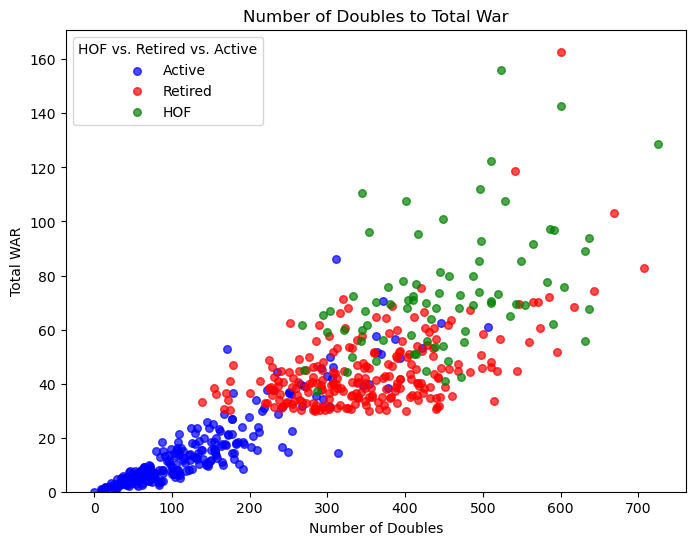

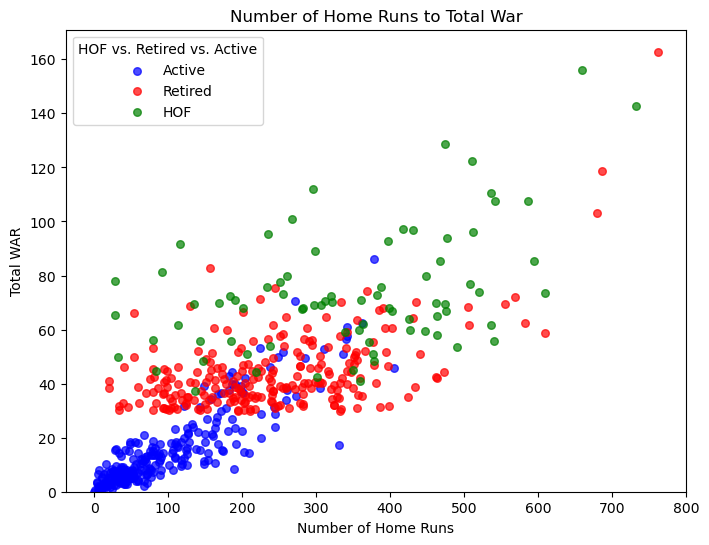

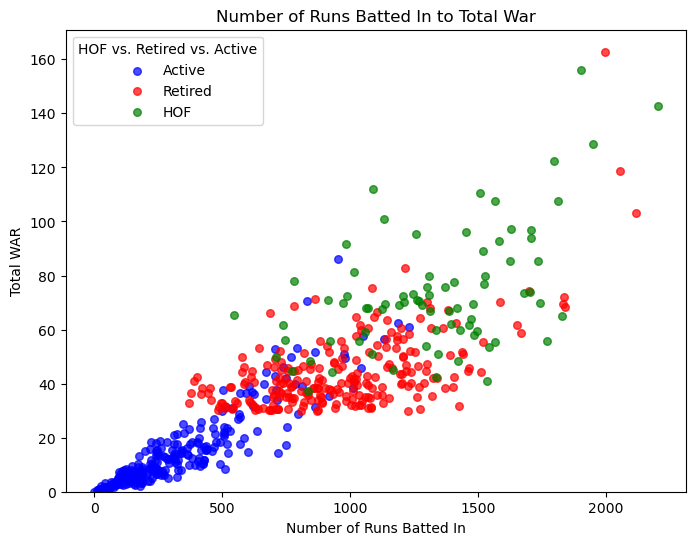

In [201]:
x_cols = ['2B', 'HR', 'RBI']
stats_cols = ['Doubles', 'Home Runs', 'Runs Batted In']

retired_players = final_inactive[final_inactive['status'] == 'retired']
hof_players = final_inactive[final_inactive['status'] == 'hof']


for index, val in enumerate(x_cols):

    fig, ax = plt.subplots(figsize=(8, 6))
    
    ax.scatter(final_active[val], final_active["WAR"], color="blue", label="Active", s=30,
                alpha=0.7)
    ax.scatter(retired_players[val], retired_players["WAR"], color="red", label="Retired", s=30,
                alpha=0.7)
    ax.scatter(hof_players[val], hof_players["WAR"], color="green", label="HOF", s=30,
                alpha=0.7)
    
    ax.set_title(f"Number of {stats_cols[index]} to Total War", fontsize=12)
    ax.set_xlabel(f"Number of {stats_cols[index]}", fontsize=10)
    ax.set_ylabel("Total WAR", fontsize=10)
    ax.set_ylim(0, None)
    ax.legend(title="HOF vs. Retired vs. Active", loc="best")

<h3><span style="color:purple; font-weight:bold">Full Projection Data vs. Retired Data</span></h3>

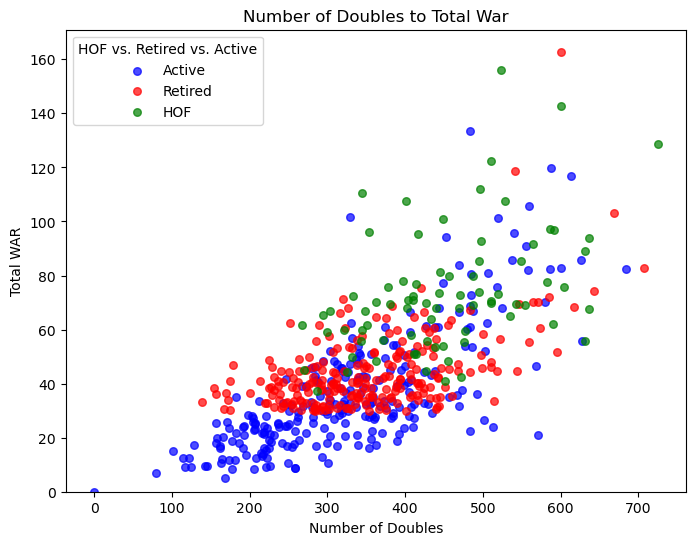

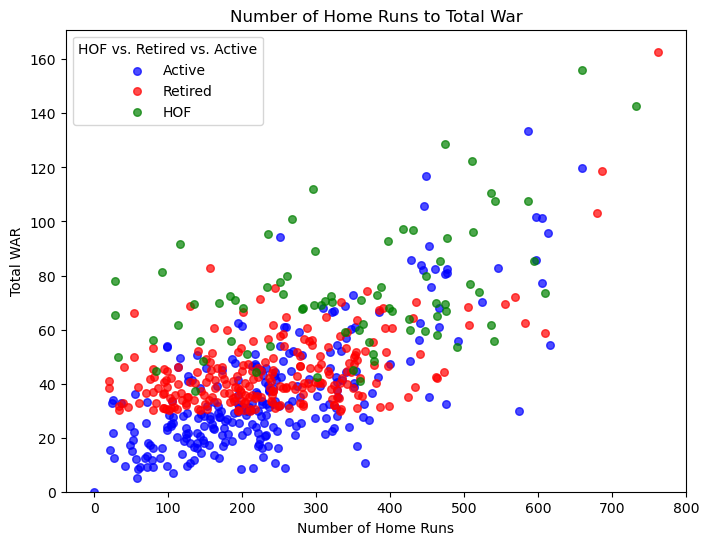

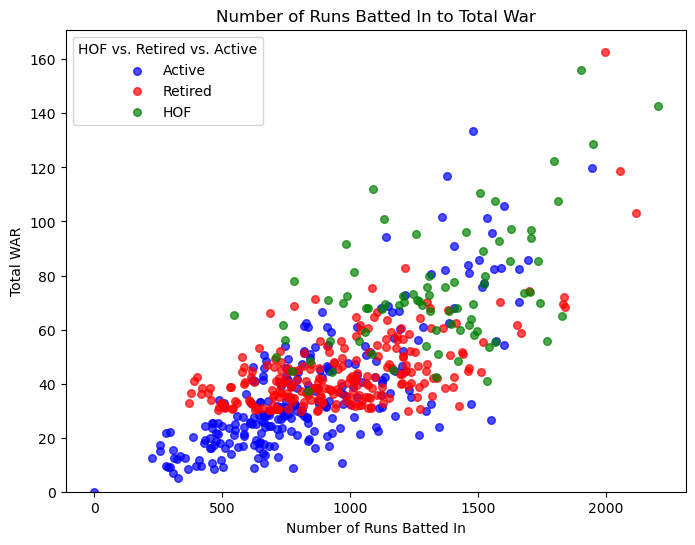

In [203]:
x_cols = ['2B', 'HR', 'RBI']
stats_cols = ['Doubles', 'Home Runs', 'Runs Batted In']

retired_players = final_inactive[final_inactive['status'] == 'retired']
hof_players = final_inactive[final_inactive['status'] == 'hof']


for index, val in enumerate(x_cols):

    fig, ax = plt.subplots(figsize=(8, 6))
    
    ax.scatter(active_projections[val], active_projections["WAR"], color="blue", label="Active", s=30,
                alpha=0.7)
    ax.scatter(retired_players[val], retired_players["WAR"], color="red", label="Retired", s=30,
                alpha=0.7)
    ax.scatter(hof_players[val], hof_players["WAR"], color="green", label="HOF", s=30,
                alpha=0.7)
    
    ax.set_title(f"Number of {stats_cols[index]} to Total War", fontsize=12)
    ax.set_xlabel(f"Number of {stats_cols[index]}", fontsize=10)
    ax.set_ylabel("Total WAR", fontsize=10)
    ax.set_ylim(0, None)
    ax.legend(title="HOF vs. Retired vs. Active", loc="best")

<h3><span style="color:purple; font-weight:bold">Projected HOF's vs. Retired Players</span></h3>

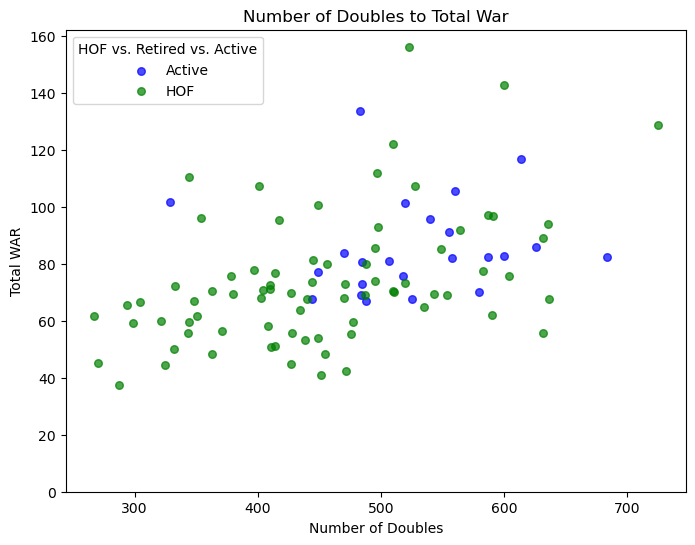

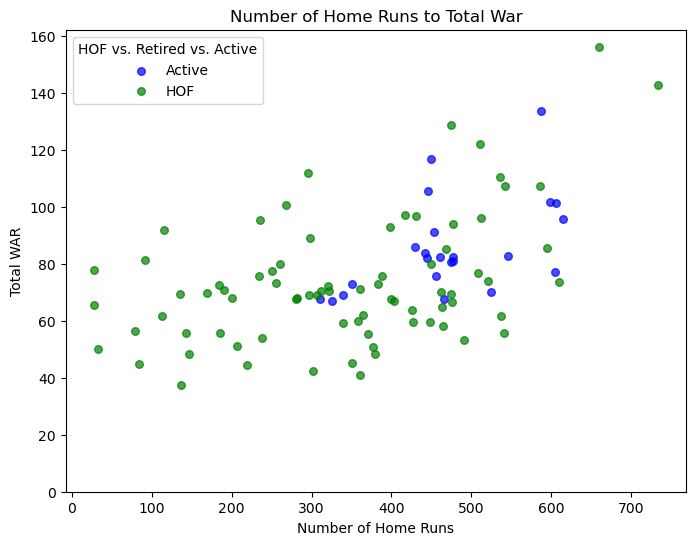

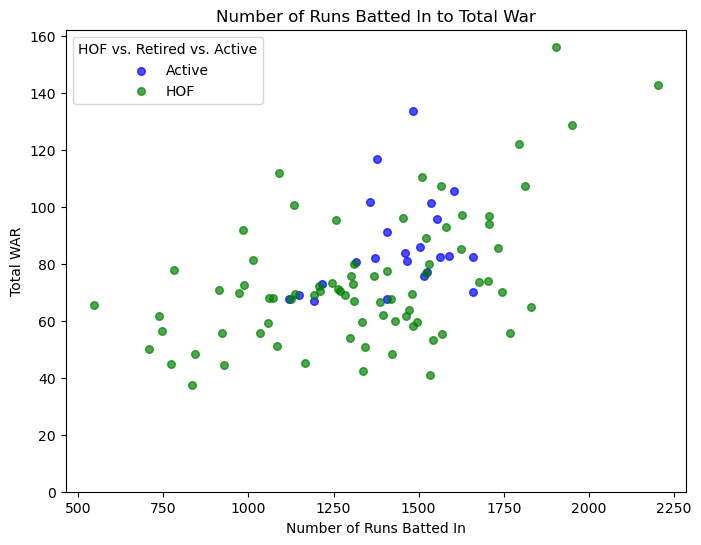

In [205]:
x_cols = ['2B', 'HR', 'RBI']
stats_cols = ['Doubles', 'Home Runs', 'Runs Batted In']

retired_players = final_inactive[final_inactive['status'] == 'retired']
hof_players = final_inactive[final_inactive['status'] == 'hof']


for index, val in enumerate(x_cols):

    fig, ax = plt.subplots(figsize=(8, 6))
    
    ax.scatter(sample[val], sample["WAR"], color="blue", label="Active", s=30,
                alpha=0.7)
    ax.scatter(hof_players[val], hof_players["WAR"], color="green", label="HOF", s=30,
                alpha=0.7)
    
    ax.set_title(f"Number of {stats_cols[index]} to Total War", fontsize=12)
    ax.set_xlabel(f"Number of {stats_cols[index]}", fontsize=10)
    ax.set_ylabel("Total WAR", fontsize=10)
    ax.set_ylim(0, None)
    ax.legend(title="HOF vs. Retired vs. Active", loc="best")